In [1]:
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"]="0"


import torch
torch.cuda.is_available()

## External imports
import os
import pandas as pd
import numpy as np
import scanpy as sc
import time
import torch

import warnings
warnings.filterwarnings("ignore")
import os.path as op


from sklearn.model_selection import train_test_split

import pandas as pd

sys.path.append('/data_nfs/og86asub/netmap/netmap-evaluation/')
from netmap.src.utils.data_utils import *
from netmap.src.utils.tf_utils import *
from netmap.src.utils.netmap_config import NetmapConfig
from netmap.src.model.negbinautoencoder import *
from netmap.src.model.negbinautoencoder import train_autoencoder
from netmap.src.model.inferrence_simple import *

from src.methods.scgenerai.scgenerai_config import ScGeneRAIConfig
from src.data_simulation.data_simulation_config import DataSimulationConfig
from captum.attr import GradientShap


from src.utils import write_config


def create_model_zoo(data_tensor, n_models = 4):
    model_zoo = []
    for _ in range(n_models):

        data_train2, data_test2 = train_test_split(data_tensor,test_size=0.95, shuffle=True)

        trained_model2 = NegativeBinomialAutoencoder(input_dim=data_tensor.shape[1], latent_dim=10, dropout_rate = 0.25)
        trained_model2 = trained_model2.cuda()

        optimizer2 = torch.optim.Adam(trained_model2.parameters(), lr=1e-4)

        trained_model2 = train_autoencoder(
                trained_model2,
                data_train2.cuda(),
                optimizer2,
                num_epochs=150

            )
        model_zoo.append(trained_model2)
    return model_zoo


from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import HDBSCAN


def set_latent_true(model_zoo):
    for mo in model_zoo:
        mo.forward_mu_only = False
        mo.forward_theta_only = False
        mo.latent_only = True
    return model_zoo


def set_all_false(model_zoo):
    for mo in model_zoo:
        mo.forward_mu_only = False
        mo.forward_theta_only = False
        mo.latent_only = False
    return model_zoo


def pair_cooccurence(u, v):
  u_arr = np.array(u)
  v_arr = np.array(v)
  term1 = np.sum(u_arr-v_arr!=0)
  return term1 / len(u_arr)

def compute_consensus_clustering(model_zoo, data_tensor, adata):
    model_zoo = set_latent_true(model_zoo)
    clusterings = {}
    for m in range(len(model_zoo)):
        latent = model_zoo[m](data_tensor.cuda())
        latent = sc.AnnData(latent.detach().cpu().numpy())
        sc.pp.neighbors(latent)
        sc.tl.umap(latent)
        latent.obs = adata.obs
        sc.tl.leiden(latent, resolution=0.1)
        clusterings[f'leiden_{m}'] = latent.obs[f'leiden']
    model_zoo = set_all_false(model_zoo)

    clusterings = pd.DataFrame(clusterings)

    latent.obs = pd.concat([latent.obs, clusterings], axis=1)
    clustering = clusterings.values.astype(int) 

    pairwise_distances_flat = pdist(clustering, metric=pair_cooccurence)
    pairwise_distances_matrix = squareform(pairwise_distances_flat)

    hdb = HDBSCAN(min_cluster_size=50, metric= 'precomputed')
    hdb.fit(pairwise_distances_matrix)
    latent.obs['consensus'] = hdb.labels_


    return latent

def set_mu_true(model_zoo):
    # forward only mu
    for mo in model_zoo:
        mo.forward_mu_only = True
        mo.forward_theta_only = False
        mo.latent_only = False
    return model_zoo

import numpy as np
from scipy.stats import nbinom

def draw_neg_binomial(mu, theta, size=1):
    """
    Draws random samples from a negative binomial distribution given mu and theta.

    Args:
        mu (float): The mean of the negative binomial distribution.
        theta (float): The dispersion parameter (often denoted as 'alpha' in some contexts,
                    related to the number of successes).
        size (int or tuple of ints, optional): The number of samples to draw.
                                            Default is 1.

    Returns:
        ndarray or scalar: Drawn samples from the negative binomial distribution.
    """
    if mu <= 0 or theta <= 0:
        raise ValueError("mu and theta must be positive.")

    p = theta / (mu + theta)
    n = theta  # theta in this parameterization corresponds to 'n' in scipy

    # scipy.stats.nbinom uses 'n' (number of successes) and 'p' (probability of success)
    samples = nbinom.rvs(n, p, size=size)
    return samples

def sample_from_vectors(mus, thetas, size=1):
    """
    Draws random samples from negative binomial distributions defined by
    corresponding elements in the mu and theta vectors.

    Args:
        mus (np.ndarray): A vector of mean parameters.
        thetas (np.ndarray): A vector of dispersion parameters.
        size (int or tuple of ints, optional): The number of samples to draw
                                            for each mu-theta pair. Default is 1.

    Returns:
        np.ndarray: An array of samples. If size is 1, the output will have the
                    same shape as mus and thetas. If size is greater than 1,
                    the output will have an additional dimension for the samples.
    """
    mus = np.asarray(mus)
    thetas = np.asarray(thetas)

    if mus.shape != thetas.shape:
        raise ValueError("mus and thetas vectors must have the same shape.")

    num_distributions = mus.shape[0]
    all_samples = []

    for i in range(num_distributions):
        mu_i = mus[i]
        theta_i = thetas[i]
        samples_i = draw_neg_binomial(mu_i, theta_i, size=size)
        all_samples.append(samples_i)

    if size == 1:
        return np.array(all_samples).flatten()
    else:
        return np.array(all_samples)



def generate_background_data(model_zoo, data_tensor, latent):
    backgrounds = {}
    for i in latent.obs['consensus'].unique():
        if i!=-1:
            backgrounds[i] = []

    for m in range(len(model_zoo)):
        # Get average params over all 
        mean_theta = get_thetas(model_zoo[m], data_tensor)
        mean_mu = get_mus(model_zoo[m], data_tensor)
        samples_mean = sample_from_vectors(mean_mu, mean_theta, size=200).T


        mean_mus = get_mus_grouping(model_zoo[m], data_tensor, latent.obs['consensus'])
        mean_thetas = get_thetas_grouping(model_zoo[m], data_tensor, latent.obs['consensus'])

        for i in backgrounds.keys():
            backgrounds[i].append(sample_from_vectors(mean_mus[i], mean_thetas[i], size=200).T)

    for b in backgrounds.keys():
        backgrounds[b] = np.concatenate(backgrounds[b])
        backgrounds[b] = torch.tensor(backgrounds[b]).cuda()

    return backgrounds


def compute_attributions(model_zoo, data_tensor, latent, gene_names, backgrounds, adata, n_top = 250):
    myexplainers = [GradientShap(mo) for mo in model_zoo]
    attributions = []
    for b in backgrounds.keys():
        aggregated_attribution, cou = inference_complete(myexplainers, data_tensor[latent.obs['consensus'] == b].cuda(), gene_names, backgrounds[b], xai_type='shap-like', num_iterations=5,n_top_genes=n_top )
        ad = attribution_to_anndata(aggregated_attribution, var=cou, obs=latent.obs[latent.obs['consensus'] == b])
        attributions.append(ad)
    return attributions
    
def concatenate_cluster_anndatas(attributions):
    aa = sc.concat(attributions, join = 'outer')
    aa.var[['source', 'target']] = aa.var.index.str.split('_')
    return aa


def run_netmap(config, dataset_config):

    start_total = time.monotonic()
    
    ## Load config and setup outputs
    os.makedirs(config.output_directory, exist_ok=True)
    sc.settings.figdir = config.output_directory
    config.write_yaml(yaml_file=op.join(config.output_directory, 'config.yaml'))

    ## load data
    adata = sc.read_h5ad(config.input_data)
    sc.pp.scale(adata)
    
    tf_genes = adata.var.index
    tf_indices, tf_gene_names = filter_tf_names(tf_genes, adata, config.tf_only)
    nr_tfs = len(tf_indices)


    ## Get the data matrix from the CustumAnndata obeject
    gene_names = np.array(adata.var.index)
    model_start = time.monotonic()
    data_tensor = torch.tensor(adata.X, dtype=torch.float32)

    model_zoo = create_model_zoo(data_tensor, n_models=2)
    latent = compute_consensus_clustering(model_zoo, data_tensor, adata)
    backgrounds = generate_background_data(model_zoo, data_tensor, latent)
    attributions = compute_attributions(model_zoo, data_tensor, latent, gene_names, backgrounds, adata)
    grn_adata = concatenate_cluster_anndatas(attributions)
    model_elapsed = time.monotonic()-model_start
    grn_adata.write_h5ad(op.join(config.output_directory,config.adata_filename))

    time_elapsed_total = time.monotonic()-start_total

    nets = [pd.read_csv(filename, sep='\t') for filename in dataset_config.edgelist]

    for net in nets:
        print(net)
        print(grn_adata.var)
        print(f" Intersection with GT1 I: {pd.merge(grn_adata.var, net, on=['source', 'target'], how='inner').shape}")

    write_config({'time_elapsed_total': time_elapsed_total, 'time_elapsed_model': model_elapsed}, file=op.join(config.output_directory, 'results.yaml'))
  




In [17]:



config = NetmapConfig.read_yaml("/data_nfs/og86asub/netmap/netmap-evaluation/results/configurations/netmap/config/config_easy/net_105_43582_net_51_43266_net_82_42088.config.yaml")
dataset_config = DataSimulationConfig.read_yaml("/data_nfs/og86asub/netmap/netmap-evaluation/results/configurations/data_simulation/config_easy/net_105_43582_net_51_43266_net_82_42088.config.yaml")




{'input_data': '/data_nfs/og86asub/netmap/netmap-evaluation/data/simulated_data/config_easy/net_105_43582_net_51_43266_net_82_42088/data.h5ad', 'output_directory': '/data_nfs/og86asub/netmap/netmap-evaluation/results/netmap/config/config_easy/net_105_43582_net_51_43266_net_82_42088', 'transcription_factors': '/data_nfs/datasets/SCENIC_DB/tf_lists/allTFs_hg38.txt', 'tf_only': False, 'penalize_error': True, 'adata_filename': 'grn_lrp.h5ad', 'grn': 'grn_lrp.tsv', 'masking_percentage': 0.1, 'masking_value': 0, 'print_every': 100, 'optimizer': 'Adam', 'learning_rate': 0.005, 'epochs': 150, 'overwrite': True, 'n_models': 10, 'n_top_edges': 100, 'test_size': 0.3, 'edge_count': 10000}


In [115]:
op.basename(op.basename("/data_nfs/og86asub/netmap/netmap-evaluation/results/configurations/data_simulation/config_easy/net_105_43582_net_51_43266_net_82_42088.config.yaml"))

'net_105_43582_net_51_43266_net_82_42088.config.yaml'

In [ ]:

start_total = time.monotonic()

## Load config and setup outputs
os.makedirs(config.output_directory, exist_ok=True)
sc.settings.figdir = config.output_directory
config.write_yaml(yaml_file=op.join(config.output_directory, 'config.yaml'))

## load data
adata = sc.read_h5ad(config.input_data)
sc.pp.scale(adata)

tf_genes = adata.var.index
tf_indices, tf_gene_names = filter_tf_names(tf_genes, adata, config.tf_only)
nr_tfs = len(tf_indices)


## Get the data matrix from the CustumAnndata obeject
gene_names = np.array(adata.var.index)
model_start = time.monotonic()
data_tensor = torch.tensor(adata.X, dtype=torch.float32)

model_zoo = create_model_zoo(data_tensor, n_models=10)
latent = compute_consensus_clustering(model_zoo, data_tensor, adata)
backgrounds = generate_background_data(model_zoo, data_tensor, latent)


Not usig TFs only aka GRN mode.
number of  genes used as TFs: 238
Epoch 1/150, Loss: 0.5348
Epoch 11/150, Loss: 0.5253
Epoch 21/150, Loss: 0.5027
Epoch 31/150, Loss: 0.4827
Epoch 41/150, Loss: 0.4791
Epoch 51/150, Loss: 0.4511
Epoch 61/150, Loss: 0.4349
Epoch 71/150, Loss: 0.4310
Epoch 81/150, Loss: 0.3933
Epoch 91/150, Loss: 0.3817
Epoch 101/150, Loss: 0.3657
Epoch 111/150, Loss: 0.3352
Epoch 121/150, Loss: 0.3086
Epoch 131/150, Loss: 0.2939
Epoch 141/150, Loss: 0.2541
Epoch 1/150, Loss: 0.5133
Epoch 11/150, Loss: 0.4821
Epoch 21/150, Loss: 0.4771
Epoch 31/150, Loss: 0.4671
Epoch 41/150, Loss: 0.4419
Epoch 51/150, Loss: 0.4250
Epoch 61/150, Loss: 0.4104
Epoch 71/150, Loss: 0.3934
Epoch 81/150, Loss: 0.3818
Epoch 91/150, Loss: 0.3516
Epoch 101/150, Loss: 0.3363
Epoch 111/150, Loss: 0.3132
Epoch 121/150, Loss: 0.3090
Epoch 131/150, Loss: 0.2732
Epoch 141/150, Loss: 0.2620
Epoch 1/150, Loss: 0.4911
Epoch 11/150, Loss: 0.4755
Epoch 21/150, Loss: 0.4657
Epoch 31/150, Loss: 0.4187
Epoch 41/

100%|██████████| 238/238 [01:03<00:00,  3.78it/s]


Creating anndata
Setting vars


100%|██████████| 238/238 [01:03<00:00,  3.76it/s]

Creating anndata
Setting vars


In [104]:
def concatenate_cluster_anndatas(attributions):
    aa = sc.concat(attributions, join = 'outer')
    # Concatenation somehow deletes the content of var
    aa.var['source']   = [l[0] for l in aa.var.index.str.split('_', expand=True)]
    aa.var['target']   = [l[1] for l in aa.var.index.str.split('_', expand=True)]
    return aa


In [105]:

time_elapsed_total = time.monotonic()-start_total

nets = [pd.read_csv(filename, sep='\t') for filename in dataset_config.edgelist]


In [110]:
attributions = compute_attributions(model_zoo, data_tensor, latent, gene_names, backgrounds, adata, n_top=50)


  0%|          | 0/238 [00:00<?, ?it/s]

100%|██████████| 238/238 [01:03<00:00,  3.77it/s]


Creating anndata
Setting vars


100%|██████████| 238/238 [01:02<00:00,  3.79it/s]

Creating anndata
Setting vars


In [111]:
attributions[0].var

,source,target
index,,
NME3_ACADVL,NME3,ACADVL
CTNNAL1_ACADVL,CTNNAL1,ACADVL
TBXA2R_ACADVL,TBXA2R,ACADVL
SLC1A2_ACADVL,SLC1A2,ACADVL
FREM2_ACADVL,FREM2,ACADVL
...,...,...
ZFHX2_ZW10,ZFHX2,ZW10
TFAP2C_ZW10,TFAP2C,ZW10
CCL27_ZW10,CCL27,ZW10


In [112]:
grn_adata = concatenate_cluster_anndatas(attributions)


In [113]:
nets = [pd.read_csv(filename, sep='\t') for filename in dataset_config.edgelist]

for net in nets:

    print(f" Intersection with GT1 I: {pd.merge(grn_adata.var, net, on=['source', 'target'], how='inner').shape}")


 Intersection with GT1 I: (17, 2)
 Intersection with GT1 I: (45, 2)


In [93]:
import netmap.src.downstream.downstreammain as d

In [35]:
aa = d.filter_low_count_edges(grn_adata, min_mean_count=0.0025)


Filtered out 48962 genes (kept 7682).


... storing 'source' as categorical
... storing 'target' as categorical


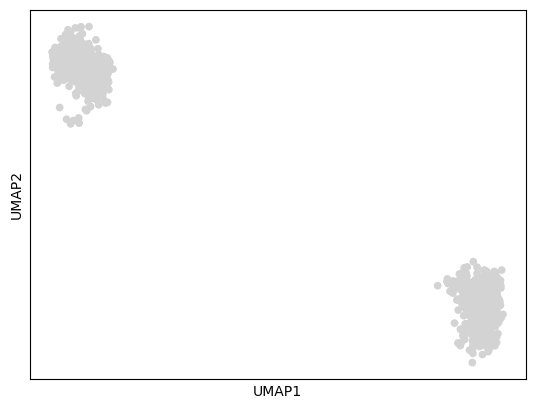

In [39]:
sc.pl.umap(aa)

In [37]:
aa = d.downstream_recipe(aa, min_perc=10, n_clusters=2)


Removed 0 edges (kept 7682 edges).


In [38]:
nets = [pd.read_csv(filename, sep='\t') for filename in dataset_config.edgelist]

for net in nets:

    print(f" Intersection with GT1 I: {pd.merge(aa.var, net, on=['source', 'target'], how='inner').shape}")


 Intersection with GT1 I: (7, 9)
 Intersection with GT1 I: (19, 9)


In [41]:
gene_inter_adata = aa.copy()
print("Gene interaintion adata")
print(gene_inter_adata)
print("\n\n Gene expression adata")
adata = adata[gene_inter_adata.obs_names,:]
adata

Gene interaintion adata
AnnData object with n_obs × n_vars = 970 × 7682
    obs: 'cell_id', 'grn', 'leiden', 'leiden_0', 'leiden_1', 'consensus', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'source', 'target', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


 Gene expression adata


View of AnnData object with n_obs × n_vars = 970 × 238
    obs: 'cell_id', 'grn', 'leiden'
    var: 'genes', 'mean', 'std'

In [53]:
results_df, all_edges, data = d.filter_signatures_by_cluster(adata, gene_inter_adata, cluster="0", top_per_source=250, min_regulon_size=10, ncores=100)

196 source based groups are found
7480 edges are found


[1] "dimensions of the resulting scores"
[1] 970 196




In [54]:
grn_adata_ = d.filter_grn_by_top_signatures(gene_inter_adata, results_df, all_edges, keep_top_ranked=100)
grn_adata_

top_n.shape: (100, 5)
Filtered edge count: 3857


AnnData object with n_obs × n_vars = 970 × 3857
    obs: 'leiden'
    var: 'source', 'target'

In [55]:
print(f"grn_adata_ : {grn_adata_}")

for net in nets:

    print(f" Intersection with GT1 I: {pd.merge(grn_adata_.var, net, on=['source', 'target'], how='inner').shape}")


grn_adata_ : AnnData object with n_obs × n_vars = 970 × 3857
    obs: 'leiden'
    var: 'source', 'target'
 Intersection with GT1 I: (3, 2)
 Intersection with GT1 I: (18, 2)


In [56]:
adata_regl = d.create_regulon_activity_adata(data, gene_inter_adata, grn_adata_)
adata_regl

AnnData object with n_obs × n_vars = 970 × 100
    obs: 'cell_id', 'grn', 'leiden', 'leiden_0', 'leiden_1', 'consensus', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    obsm: 'X_umap'

In [57]:
net.source.unique()

array(['TFAP2A', 'TFAP2B', 'TFAP2C', 'TFAP2D', 'AEBP1', 'AEBP2'],
      dtype=object)

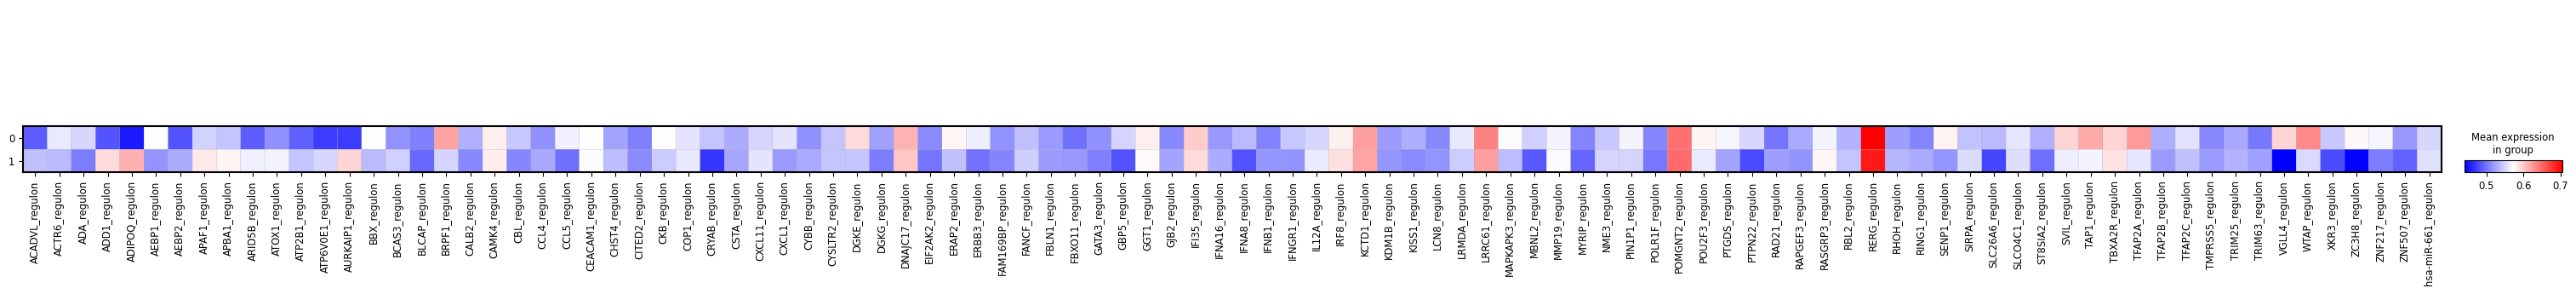

In [58]:
marker_genes = list(adata_regl.var.index)

ax = sc.pl.matrixplot(adata_regl, marker_genes, groupby='leiden', cmap='bwr')

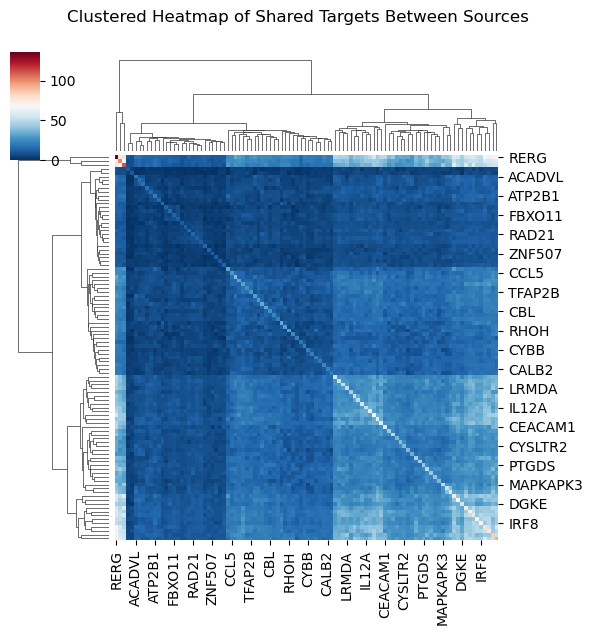

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Load your data
df = grn_adata_.var

# Step 1: Build mapping from source to set of targets
source_targets = df.groupby('source')['target'].apply(set)

# Step 2: Create similarity matrix
sources = source_targets.index.tolist()
shared_target_matrix = pd.DataFrame(0, index=sources, columns=sources)

# Step 3: Count shared targets for each source pair
for src1, src2 in combinations(sources, 2):
    shared = len(source_targets[src1] & source_targets[src2])
    shared_target_matrix.loc[src1, src2] = shared
    shared_target_matrix.loc[src2, src1] = shared

# Fill diagonal with number of targets per source
for src in sources:
    shared_target_matrix.loc[src, src] = len(source_targets[src])

# Step 4: Clustered heatmap
sns.clustermap(shared_target_matrix, cmap='RdBu_r', figsize=(6, 6), metric='euclidean', method='average')
plt.suptitle('Clustered Heatmap of Shared Targets Between Sources', y=1.05)
plt.show()

In [62]:
# Downstream processing defaults
DEFAULT_MIN_PERC = 10           # Minimum % of cells expressing a gene to keep it
DEFAULT_N_CLUSTERS = 2          # Number of clusters for filtering/labeling

# Edge filtering
DEFAULT_MIN_MEAN_COUNT = 0.0005  # Minimum mean edge weight (strength) to retain

# Signature filtering
DEFAULT_TOP_PER_SOURCE = 200    # Max signatures to retain per source gene
DEFAULT_MIN_REGULON_SIZE = 10   # Minimum number of targets in a regulon to retain it
DEFAULT_NCORES = 100            # Number of parallel workers to use

# GRN filtering
DEFAULT_KEEP_TOP_RANKED = 100    # Top N signatures to keep from filtered results


In [64]:
# Apply defaults explicitly for clarity
aa = d.downstream_recipe(grn_adata, min_perc=DEFAULT_MIN_PERC, n_clusters=DEFAULT_N_CLUSTERS)

aa = d.filter_low_count_edges(aa, min_mean_count=DEFAULT_MIN_MEAN_COUNT)

gene_inter_adata = aa.copy()

# Align adata to gene interaction AnnData
adata = adata[gene_inter_adata.obs_names, :]

clusters_adata = []
for cluster_ in gene_inter_adata.obs["leiden"].unique():

    print(f"Cluster: {cluster_}")
    # Filter significant signatures
    results_df, all_edges, data = d.filter_signatures_by_cluster(
        adata,
        gene_inter_adata,
        cluster=cluster_,
        top_per_source=DEFAULT_TOP_PER_SOURCE,
        min_regulon_size=DEFAULT_MIN_REGULON_SIZE,
        ncores=DEFAULT_NCORES
    )

    # Keep only most significant interactions
    grn_adata_ = d.filter_grn_by_top_signatures(
        gene_inter_adata,
        results_df,
        all_edges,
        keep_top_ranked=DEFAULT_KEEP_TOP_RANKED
    )
    clusters_adata.append(grn_adata_)
    print(f"Cluster {cluster_} GRN size: {grn_adata_.shape}")



Removed 0 edges (kept 56644 edges).
Filtered out 0 genes (kept 56644).
Cluster: 0
238 source based groups are found
56644 edges are found


[1] "dimensions of the resulting scores"
[1] 970 238


top_n.shape: (100, 5)
Filtered edge count: 20000
Cluster 0 GRN size: (970, 20000)
Cluster: 1
238 source based groups are found
56644 edges are found


[1] "dimensions of the resulting scores"
[1] 970 238


top_n.shape: (100, 5)
Filtered edge count: 20000
Cluster 1 GRN size: (970, 20000)


In [65]:
clusters_adata

[AnnData object with n_obs × n_vars = 970 × 20000
     obs: 'leiden'
     var: 'source', 'target',
 AnnData object with n_obs × n_vars = 970 × 20000
     obs: 'leiden'
     var: 'source', 'target']

In [43]:
myad = sc.read_h5ad('/data_nfs/og86asub/netmap/netmap-evaluation/results/csnet/config/config_easy/net_51_43266_net_82_42088_net_105_43582/csnet.csn.h5ad')

In [45]:

myad.X.nonzero()

(array([  2,   3,   4,   8,  40,  40,  40,  40,  40,  40,  40,  55,  56,
         73,  83,  83,  83,  87, 118, 161, 178, 182, 182, 182, 184, 201,
        203, 210, 210, 210, 210, 212, 215, 215, 215, 233, 278, 281, 283,
        285, 299, 301, 305, 315, 321, 324, 324, 324, 330, 361, 366, 366,
        366, 372, 427, 463, 472, 492, 502, 513, 514, 517, 517, 517, 541,
        560, 560, 560, 566, 577, 580, 595, 595, 595, 595, 609, 619, 643,
        644, 658, 687, 706, 719, 735, 744, 744, 744, 758, 780, 792, 792,
        792, 795, 807, 828, 831, 839, 847, 916, 918, 931, 940, 949, 957,
        990, 990, 990, 990], dtype=int32),
 array([10755, 30353, 44454, 29397,  9167, 29312, 29397, 29408, 29460,
        32015, 44391, 30353, 21749, 30353, 21749, 21842, 43883, 30353,
        30353, 29397, 44454, 21749, 21842, 43883, 29397, 44454, 10755,
        29397, 29401, 30349, 30353, 44454, 10755, 10896, 44313, 30353,
        29397, 30353, 44454, 30353, 29397, 30353, 44454, 29397, 29397,
        44454, 444

In [42]:
myad[40,].X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7 stored elements and shape (1, 56644)>

In [18]:

## Load config and setup outputs
os.makedirs(config.output_directory, exist_ok=True)
sc.settings.figdir = config.output_directory
config.write_yaml(yaml_file=op.join(config.output_directory, 'config.yaml'))

## load data
adata = sc.read_h5ad(config.input_data)

In [19]:
adata.var

,genes
ACADVL,ACADVL
ACTR6,ACTR6
ADA,ADA
ADD1,ADD1
ADIPOQ,ADIPOQ
...,...
ZFHX2,ZFHX2
ZNF217,ZNF217
ZNF503,ZNF503
ZNF507,ZNF507


In [26]:
import itertools
edgenames = []
for i in itertools.product(adata.var['genes'], adata.var['genes']):
    edgenames.append(f"{i[0]}_{i[1]}")

In [27]:
edgenames

['ACADVL_ACADVL',
 'ACADVL_ACTR6',
 'ACADVL_ADA',
 'ACADVL_ADD1',
 'ACADVL_ADIPOQ',
 'ACADVL_AEBP1',
 'ACADVL_AEBP2',
 'ACADVL_APAF1',
 'ACADVL_APBA1',
 'ACADVL_ARID5B',
 'ACADVL_ATOX1',
 'ACADVL_ATP2B1',
 'ACADVL_ATP6V0E1',
 'ACADVL_AURKAIP1',
 'ACADVL_BBX',
 'ACADVL_BCAS3',
 'ACADVL_BLCAP',
 'ACADVL_BLOC1S1',
 'ACADVL_BPIFB1',
 'ACADVL_BRPF1',
 'ACADVL_CALB2',
 'ACADVL_CAMK4',
 'ACADVL_CASP1',
 'ACADVL_CBL',
 'ACADVL_CCL19',
 'ACADVL_CCL27',
 'ACADVL_CCL4',
 'ACADVL_CCL5',
 'ACADVL_CD36',
 'ACADVL_CD5',
 'ACADVL_CD80',
 'ACADVL_CEACAM1',
 'ACADVL_CFB',
 'ACADVL_CHST2',
 'ACADVL_CHST4',
 'ACADVL_CITED2',
 'ACADVL_CKB',
 'ACADVL_CLIC3',
 'ACADVL_COMMD7',
 'ACADVL_COP1',
 'ACADVL_CREB5',
 'ACADVL_CRYAB',
 'ACADVL_CSTA',
 'ACADVL_CTNNA2',
 'ACADVL_CTNNAL1',
 'ACADVL_CTSS',
 'ACADVL_CXCL1',
 'ACADVL_CXCL10',
 'ACADVL_CXCL11',
 'ACADVL_CYBB',
 'ACADVL_CYSLTR2',
 'ACADVL_DCBLD2',
 'ACADVL_DGKE',
 'ACADVL_DGKG',
 'ACADVL_DNAJC17',
 'ACADVL_DUSP16',
 'ACADVL_ECE1',
 'ACADVL_ECM1',
 'ACADVL_EI